In [1]:
!pip install xlrd==1.2.0

In [2]:
import sys
import numpy as np
from scipy.special import expit

class BPNN(object):
    def __init__(self,X,Y,q,l,epoch_times=1000,Eta=0.001,visible=False):
        '''args:
            X(n*d):样本集属性的np数组,包含n个样本,每个样本包含d个属性
            Y(n*l):样本集标签的np数组
            gama:隐藏层神经元的阈值[1*q]
            theta:输出层神经元的阈值[1*l]
            n:样本数
            d:属性数
            q:隐藏层中神经元数
            l:分类数
            v:输入层->隐藏层的权重向量[(d+1)*q]
            w:隐藏层->输出层的权重向量[q*l]
            epoch_times:梯度下降法中的迭代次数
            Eta:梯度下降法中的学习率
            visible:训练过程是否可视化
        '''
        self.X=X
        self.Y=Y
        self.n,self.d=self.X.shape
        self.q=q
        self.l=l
        self.v,self.w=self.Init_wgt()
        self.gama,self.theta=self.Init_threshold()
        self.epoch_times=epoch_times
        self.Eta=Eta
        self.visible=visible

    def Add_bias(self,X):               #对X(1*d)添加偏置项->X_new(1*(d+1))
        X_new=np.ones((X.shape[0]+1))
        X_new[1:]=X
        return X_new
    def Init_wgt(self):                 #初始化v和w
        v=np.random.uniform(-1.0,1.0,size=(self.d+1)*self.q)
        v=v.reshape(self.d+1,self.q)
        w=np.random.uniform(-1.0,1.0,size=self.q*(self.l))
        w=w.reshape(self.q,self.l)
        return v,w
    def Init_threshold(self):           #初始化gama和theta
        gama=np.random.uniform(-1.0,1.0,size=self.q)
        gama=gama.reshape(1,self.q)
        theta=np.random.uniform(-1.0,1.0,size=self.l)
        theta=theta.reshape(1,self.l)
        return gama,theta

    def Sigmoid(self,z):                #激活函数
        return expit(z)
    def Sigmoid_gradient(self,z):       #激活函数的梯度
        sg=self.Sigmoid(z)
        return sg*(1-sg)

    def FP(self,X):                     #将输入的训练/测试样本正向传播
        X_new=self.Add_bias(X)          #X_new:1*(d+1)
        alpha=np.matmul(X_new,self.v)   #alpha:1*q
        b=self.Sigmoid(alpha-self.gama) #b:1*q
        beita=np.matmul(b,self.w)       #beita:1*l
        y=self.Sigmoid(beita-self.theta)#y:1*l
        return alpha,b,beita,y

    def Get_cost(self,y,label):         #损失函数
        tmp=(y-label)*(y-label)/2
        cost=np.mean(tmp)
        return cost

    def GD(self,X,b,y,label):           #反向传播,修正v,w,gama,theta
        g=y*(1-y)*(y-label)             #g:1*l
        tmp1=np.matmul(g,self.w.T)      #计算Σw[h][j]*g[j],tmp:1*q
        e=b*(1-b)*tmp1                  #b:1*q,e:1*q
        X_new=self.Add_bias(X)

        self.w-=self.Eta*np.matmul(b.T,g)
        self.theta+=self.Eta*g
        tmp2=X_new.T.reshape(-1,1)
        self.v-=self.Eta*np.matmul(tmp2,e)
        self.gama+=self.Eta*e
        return self

    def Pred(self,X):                   #对输入的`测试样本集`预测分类结果
        pred=[]
        for i in range(X.shape[0]):
            alpha,b,beita,y=self.FP(X[i])
            pred_tmp=np.argmax(y,axis=-1)   #预测值取最大的分类作为标签
            pred.append(pred_tmp[0])
        return pred

    def Train(self):
        costs=[]                        #存储每次训练后的损失函数
        for i in range(self.epoch_times):
            if self.visible:
                sys.stderr.write("\rEpoch times: %d/%d "%(i+1,self.epoch_times)+"▋"*(i//(self.epoch_times//20)))
                sys.stderr.flush()
            cost_tmp=[]
            for j in range(len(self.X)):#对每个样本进行训练
                alpha,b,beita,y=self.FP(self.X[j])
                cost=self.Get_cost(y,self.Y[j])
                cost_tmp.append(cost)
                self.GD(self.X[j],b,y,self.Y[j])
            costs.append(np.mean(np.array(cost_tmp)))
        return costs

Epoch times: 10000/10000 ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋


Accuracy of classification: 100.00%


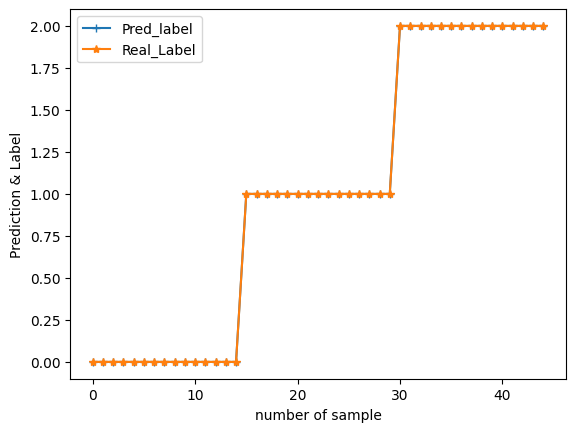

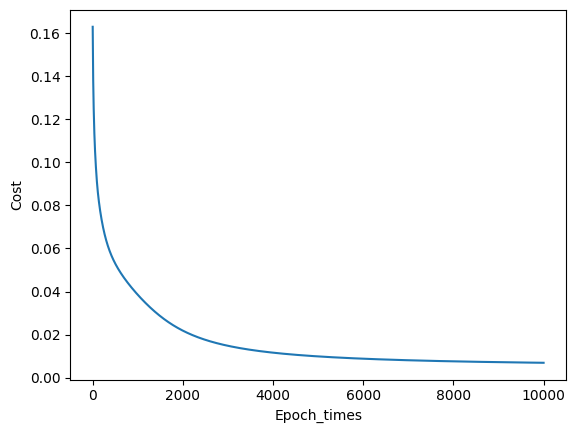

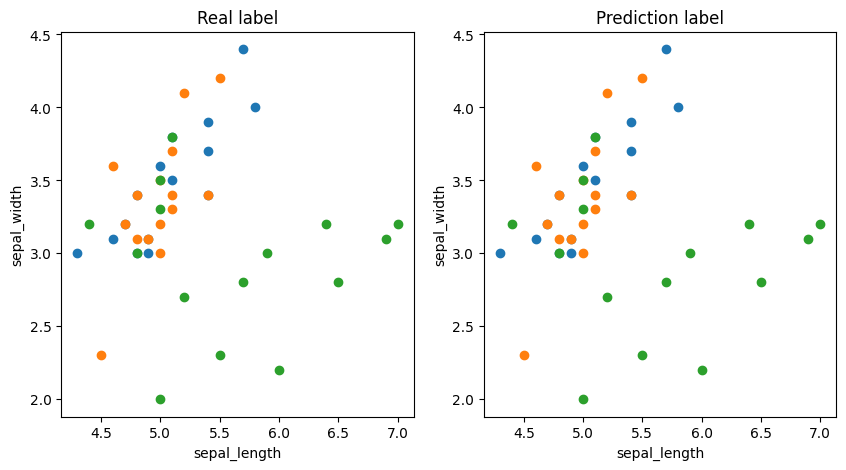

In [3]:
'''鸢尾花数据集
    150个样本,按7:3划分为训练集和测试集
    3个类别('setosa', 'versicolor', 'virginica'),
    4个属性('sepal length','sepal width','petal length','petal width'),
    训练神经网络模型并测试准确率
    呈现训练过程,绘制分类结果,评估模型准确性
'''
import xlrd
from xlrd import open_workbook
import numpy as np
import matplotlib.pyplot as plt

#读取数据并将其按7:3划分为训练集和测试集
path=r"F:\code\code\python\exp2\data\iris_data.xlsx"
book=open_workbook(path)
sheet=book.sheets()[0]          #打开sheet0
nrow=sheet.nrows                #行数
ncol=sheet.ncols                #列数
label_dic={'Iris-setosa':0,'Iris-versicolor':1,'Iris-virginica':2}  #标签序列化
data_train=[]                   #训练集属性(n*d)
data_test=[]                    #训练集标签(n*l)
label_train=[]                  #测试集属性
label_test=[]                   #测试集标签(one-hot)
labeln_test=[]                  #测试集标签(分类值)
for i in range(1,nrow):
    row=sheet.row_values(i)
    one_hot=[0]*len(label_dic)  #样本分类标签的one-hot向量
    label=label_dic[row[4]]
    one_hot[label]=1
    row.pop(4)                  #保留样本属性,删除标签
    if(i%10<7):
        data_train.append(row)
        label_train.append(one_hot)
    else:
        data_test.append(row)
        label_test.append(one_hot)
        labeln_test.append(label)
data_train=np.array(data_train)
data_test=np.array(data_test)
label_train=np.array(label_train)
label_test=np.array(label_test)
labeln_test=np.array(labeln_test)

#实例化BPNN对象并进行训练
d=len(data_train[0])            #属性数
l=len(label_dic)                #分类数
n=nrow                          #样本数
ep=10000                        #训练次数
q=10                            #隐藏层神经元数
bpnn=BPNN(data_train,label_train,q,l,ep,0.001,True)
cst=bpnn.Train()                #训练过程的损失函数
pred=bpnn.Pred(data_test)       #训练后的分类结果

#计算准确率
acc=0
for i in range(len(pred)):
    if(pred[i]==labeln_test[i]):
        acc+=1
acc/=len(pred)
print('\nAccuracy of classification: %.2f%%'%(acc*100))

#绘制预测值/标签值-编号的图像
plt.plot(pred,marker='+')
plt.plot(labeln_test,marker='*')
plt.ylabel('Prediction & Label')
plt.xlabel('number of sample')
plt.legend(['Pred_label','Real_Label'])
plt.show()

#绘制损失函数
plt.plot(range(len(cst)),cst)
plt.ylabel('Cost')
plt.xlabel('Epoch_times')
plt.show()

#以sepal_length和sepal_width属性为例绘制多分类结果
#将预测结果按类分开
pred0=[]                        #预测为Iris-setosa类的样本点集合
pred1=[]                        #预测为Iris-versicolor类的样本点集合
pred2=[]                        #预测为Iris-virginica类的样本点集合
for i in range(len(pred)):
    if(pred[i]==0):
        pred0.append(data_train[i][:2])
    elif(pred[i]==1):
        pred1.append(data_train[i][:2])
    else:
        pred2.append(data_train[i][:2])
pred0=np.array(pred0)
pred1=np.array(pred1)
pred2=np.array(pred2)
#绘制真实分类和预测分类
fig0=plt.figure(figsize=(10,5))
ax=plt.subplot(121)             #真实分类
ax.scatter(data_train[:15,0],data_train[:15,1])
ax.scatter(data_train[15:30,0],data_train[15:30,1])
ax.scatter(data_train[30:45,0],data_train[30:45,1])
ax.set_xlabel('sepal_length')
ax.set_ylabel('sepal_width')
ax.set_title("Real label")
ax=plt.subplot(122)             #预测分类
ax.scatter(pred0[:,0],pred0[:,1])
ax.scatter(pred1[:,0],pred1[:,1])
ax.scatter(pred2[:,0],pred2[:,1])
ax.set_xlabel('sepal_length')
ax.set_ylabel('sepal_width')
ax.set_title("Prediction label")
plt.show()

Epoch times: 1000/1000 ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋


Accuracy of classification: 56.67%


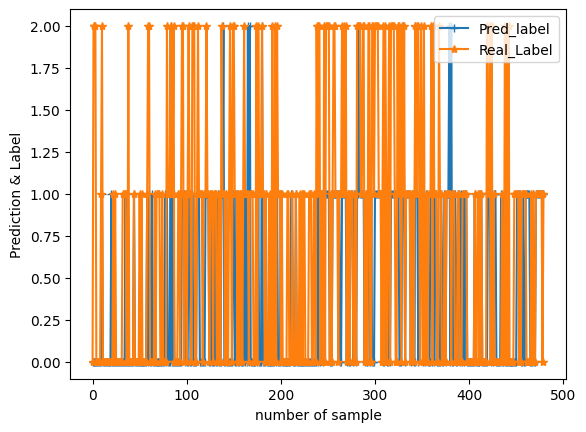

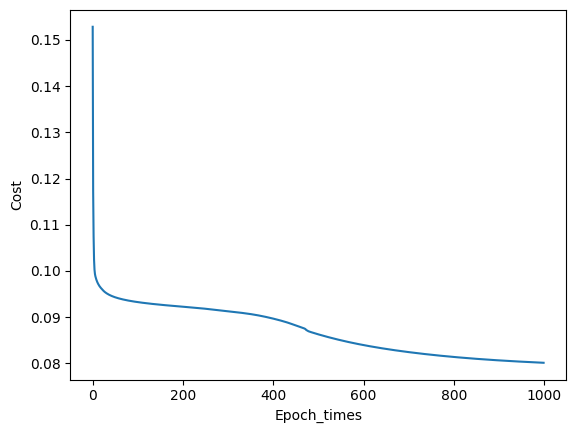

In [36]:
'''红酒品质数据集
    1600个样本,按7:3划分为训练集和测试集
    3个类别('Bad','Normal','Good')
    11个属性('fixed acidity','volatile acidity','citric acid','residual sugar','chlorides','free sulfur dioxide','total sulfur dioxide','density','pH','sulphates','alcohol')
    训练神经网络模型并测试准确率
    呈现训练过程,绘制分类结果,评估模型准确性
'''
import xlrd
from xlrd import open_workbook
import numpy as np
import matplotlib.pyplot as plt

#读取数据并将其按7:3划分为训练集和测试集
path=r"F:\code\code\python\exp2\data\winequality_data.xlsx"
book=open_workbook(path)
sheet=book.sheets()[0]          #打开sheet0
nrow=sheet.nrows                #行数
ncol=sheet.ncols                #列数
label_dic={'Bad':0,'Normal':1,'Good':2}     #标签序列化
data_train=[]                   #训练集属性(n*d)
data_test=[]                    #训练集标签(n*l)
label_train=[]                  #测试集属性
label_test=[]                   #测试集标签(one-hot)
labeln_test=[]                  #测试集标签(分类值)
for i in range(1,nrow):
    row=sheet.row_values(i)
    one_hot=[0]*len(label_dic)  #样本分类标签的one-hot向量
    label=label_dic[row[11]]
    one_hot[label]=1
    row.pop(11)                 #保留样本属性,删除标签
    if(i%10<7):
        data_train.append(row)
        label_train.append(one_hot)
    else:
        data_test.append(row)
        label_test.append(one_hot)
        labeln_test.append(label)
data_train=np.array(data_train)
data_test=np.array(data_test)
label_train=np.array(label_train)
label_test=np.array(label_test)
labeln_test=np.array(labeln_test)

#实例化BPNN对象并进行训练
d=len(data_train[0])            #属性数
l=len(label_dic)                #分类数
n=nrow                          #样本数
ep=1000                      #训练次数
q=30                            #隐藏层神经元数
bpnn=BPNN(data_train,label_train,q,l,ep,0.001,True)
cst=bpnn.Train()                #训练过程的损失函数
pred=bpnn.Pred(data_test)       #训练后的分类结果

#计算准确率
acc=0
for i in range(len(pred)):
    if(pred[i]==labeln_test[i]):
        acc+=1
acc/=len(pred)
print('\nAccuracy of classification: %.2f%%'%(acc*100))

#绘制预测值/标签值-编号的图像
plt.plot(pred,marker='+')
plt.plot(labeln_test,marker='*')
plt.ylabel('Prediction & Label')
plt.xlabel('number of sample')
plt.legend(['Pred_label','Real_Label'])
plt.show()

#绘制损失函数
plt.plot(range(len(cst)),cst)
plt.ylabel('Cost')
plt.xlabel('Epoch_times')
plt.show()